# MEM: iMAT

## Visualisation of the tissue-specific model

### Plotting metabolic tasks 

In this notebook, the list of metabolic tasks on existing mammalian genome-scale models obtained from Richelle et al. (2019) is tested on the tissue-specific *Salmo salar*-model extracted by using the iMAT MEM.

In [1]:
import os
os.chdir('../../salmote')

from custom_tests.test_custom_tests import *
import cobra

os.chdir('../msc-hm')

In [2]:
sasa_iMAT = cobra.io.load_matlab_model('tissue_models/matlab_models/iMAT_model.mat')
sasa_iMAT

Using license file /Users/Haavard/gurobi.lic
Academic license - for non-commercial use only - expires 2021-01-02


<Model iMAT_model at 0x108835820>

No objective expression??

In [3]:
tasksheet = 'Tasks.xlsx'
tasks = parseTaskSheet(tasksheet)

In [4]:
table = str.maketrans({'[': '_', ']': ''})
for task in tasks:
    task.insert(11, 'EQU', 0)
    for ind, row in task.iterrows():
        if row.IN:
            task.at[ind,'IN'] = row.IN.translate(table)
        if row.OUT:
            task.at[ind,'OUT'] = row.OUT.translate(table)

#### Run tasks

In [5]:
sc = score_chart(sasa_iMAT, tasks)

cobra/util/solver.py:416 UserWarning: solver status is 'infeasible'


In [6]:
sc

Description  \
1.0    Oxidative phosphorylation via NADH-coenzyme Q ...   
2.0    Oxidative phosphorylation via succinate-coenzy...   
3.0    Krebs cycle - oxidative decarboxylation of pyr...   
4.0                        Krebs cycle - NADH generation   
5.0    ATP regeneration from glucose (normoxic condit...   
...                                                  ...   
206.0  Biosynthesis of Tn_antigen (Glycoprotein N-ace...   
207.0  Keratan sulfate biosynthesis from O-glycan (co...   
208.0  Keratan sulfate biosynthesis from O-glycan (co...   
209.0                        Keratan sulfate degradation   
210.0         Keratan sulfate biosynthesis from N-glycan   

                                        Result  
1.0            Input metabolite missing: q10_m  
2.0            <Solution 0.000 at 0x1201d1a00>  
3.0            <Solution 0.000 at 0x1201e3880>  
4.0       <Solution infeasible at 0x1201f24c0>  
5.0       <Solution infeasible at 0x1201fc400>  
...                                        ...  
206.0     Input metabolite missing: Ser__Thr_g  
207.0        Input metabolite missing: core2_g  
208.0        Input metabolite missing: core4_g  
209.0          Input metabolite missing: ksi_l  
210.0  Input metabolite missing: l2fn2m2masn_g  

[210 rows x 2 columns]

#### Collect results in dict  
Where the name of the model is the key, and the score chart is the value.

In [7]:
sd = {'model': sc}
sd

{'model':                                              Description  \
 1.0    Oxidative phosphorylation via NADH-coenzyme Q ...   
 2.0    Oxidative phosphorylation via succinate-coenzy...   
 3.0    Krebs cycle - oxidative decarboxylation of pyr...   
 4.0                        Krebs cycle - NADH generation   
 5.0    ATP regeneration from glucose (normoxic condit...   
 ...                                                  ...   
 206.0  Biosynthesis of Tn_antigen (Glycoprotein N-ace...   
 207.0  Keratan sulfate biosynthesis from O-glycan (co...   
 208.0  Keratan sulfate biosynthesis from O-glycan (co...   
 209.0                        Keratan sulfate degradation   
 210.0         Keratan sulfate biosynthesis from N-glycan   
 
                                         Result  
 1.0            Input metabolite missing: q10_m  
 2.0            <Solution 0.000 at 0x1201d1a00>  
 3.0            <Solution 0.000 at 0x1201e3880>  
 4.0       <Solution infeasible at 0x1201f24c0>  
 5.0   

#### Which rows should fail?
Score charts are scored in a dict where the keys are names/commits associated with the model. 
These names will be displayed on the x-axis.  
In addition, the tasks supposed to fail will be framed by a black rectangle.

In [8]:
should_fail = [task['SHOULD FAIL'].iloc[0] for task in tasks]
sf = [index for index in range(len(should_fail)) if should_fail[index] == 1.0]

In [9]:
sf

[6, 81, 98, 102, 105, 107, 110, 114, 122, 130, 132, 140, 146, 171, 173]

#### Combine the results to one dataframe with the task-description as index and key as column names.

In [10]:
chart = combine_charts(sd)
chart

model
Description                                                                                
Oxidative phosphorylation via NADH-coenzyme Q o...          Input metabolite missing: q10_m
Oxidative phosphorylation via succinate-coenzym...          <Solution 0.000 at 0x1201d1a00>
Krebs cycle - oxidative decarboxylation of pyru...          <Solution 0.000 at 0x1201e3880>
Krebs cycle - NADH generation                          <Solution infeasible at 0x1201f24c0>
ATP regeneration from glucose (normoxic conditi...     <Solution infeasible at 0x1201fc400>
...                                                                                     ...
Biosynthesis of Tn_antigen (Glycoprotein N-acet...     Input metabolite missing: Ser__Thr_g
Keratan sulfate biosynthesis from O-glycan (cor...        Input metabolite missing: core2_g
Keratan sulfate biosynthesis from O-glycan (cor...        Input metabolite missing: core4_g
Keratan sulfate degradation                                 Input metabolite missing: ksi_l
Keratan sulfate biosynthesis from N-glycan          Input metabolite missing: l2fn2m2masn_g

[210 rows x 1 columns]

#### Print out which tasks are feasible, infeasible, and which tasks are missing a metabolite to perform the tasks

In [11]:
feasible_sols = []
infeasible_sols = []
missing_met = []
for ind, task in enumerate(chart.index):
    try:
        if chart.model[ind].status == 'optimal':
            feasible_sols.append(task)
        elif chart.model[ind].status == 'infeasible':
            infeasible_sols.append(task)
    except AttributeError:
        missing_met.append(task)

should_fail = [task for task in chart.index[sf]]

In [12]:
from termcolor import colored

print(colored('Feasible tasks: \n', color='yellow', attrs = ['bold', 'underline']))
print('\n'.join(feasible_sols))

print(colored('\n\n\n Infeasible tasks: \n', color='green', attrs = ['bold', 'underline']))
print('\n'.join(infeasible_sols))

print(colored('\n\n\n Missing metabolite: \n', color='magenta', attrs = ['bold', 'underline']))
print('\n'.join(missing_met))

print(colored('\n\n\n Should fail: \n', color='blue', attrs = ['bold', 'underline']))
print('\n'.join(should_fail))

Feasible tasks: 

Oxidative phosphorylation via succinate-coenzyme Q oxidoreductase (COMPLEX II)
Krebs cycle - oxidative decarboxylation of pyruvate
ATP generation from glucose (hypoxic conditions) - glycolysis
Presence of the thioredoxin system through the thioredoxin reductase activity
Inosine monophosphate synthesis (IMP)
Guanosine triphosphate synthesis (GTP)
AMP salvage from adenine
IMP salvage from hypoxanthine
GMP salvage from guanine
Ethanol to acetaldehyde
Glucose to lactate conversion
Malate to pyruvate conversion
Synthesis of fructose-6-phosphate from erythrose-4-phosphate (HMP shunt)
Synthesis of ribose-5-phosphate
Fructose degradation (to glucose-3-phosphate)
Fructose to glucose conversion (via fructose-6-phosphate)
Mannose degradation (to fructose-6-phosphate)
N-Acetylglucosamine synthesis
Alanine synthesis
Alanine degradation
Synthesis of alanine from glutamine
Synthesis of aspartate from glutamine
Asparagine degradation
Aspartate synthesis
Aspartate degradation
Conversi

### Parsimonious Flux Balance Analysis (pFBA)

#### Extract only optimal solutions

In [13]:
optimal_sols = []
for ind, res in enumerate(sc.Result):
    if isinstance(res, str):
        continue
    if res.status == 'optimal':
        optimal_sols.append(ind)
        
print(f'Optimal solutions: {len(optimal_sols)}')

Optimal solutions: 41


#### pFBA score charts (modified `score_chart()`-function)

In [14]:
# Collect all optimal tasks in a list (becomes a list of dataframes)
optimal_tasks = [tasks[i] for i in optimal_sols]

pfba_chart = pd.DataFrame(columns=['Description', 'Solution'])
for task in optimal_tasks:
    with sasa_iMAT as in_model:
        t_id = sum(task.ID)
        descr = [elem for elem in task.DESCRIPTION][0]
        try:
            result = run_task(in_model, parse(task), method='pfba')
        except:
            result = False
    row = pd.Series({'Description': descr, 'Solution': result}).to_frame(t_id).T
    pfba_chart = pfba_chart.append(row)

pfba_chart = pfba_chart.reset_index(drop=True)

#### Iterate over each solution and collect non-zero reaction fluxes and associated genes in two new columns (`Reactions` and `Genes`)

In [15]:
pfba_chart['Reactions'] =  np.empty((len(pfba_chart), 0)).tolist()
pfba_chart['Genes'] = np.empty((len(pfba_chart), 0)).tolist()

for ind, sol in enumerate(pfba_chart['Solution']):
    reactions = {}
    genes = []
    for rx, flux in sol.fluxes.items():
        if flux != 0:                   # Change threshold to e.g. 1e-6
            reactions[rx] = flux        # Maybe e.g. round(flux, 4)
            try:
                gns = sasa_iMAT.reactions.get_by_id(rx).genes
                if len(gns) > 0:
                    genes += [x for x in gns]
            except KeyError:
                continue
    pfba_chart.Genes[ind] = list(set(genes)) # Removing duplicates from gene list
    pfba_chart.Reactions[ind] = reactions

In [16]:
pfba_chart

Description  \
0   Oxidative phosphorylation via succinate-coenzy...   
1   Krebs cycle - oxidative decarboxylation of pyr...   
2   ATP generation from glucose (hypoxic condition...   
3   Presence of the thioredoxin system through the...   
4               Inosine monophosphate synthesis (IMP)   
5              Guanosine triphosphate synthesis (GTP)   
6                            AMP salvage from adenine   
7                       IMP salvage from hypoxanthine   
8                            GMP salvage from guanine   
9                             Ethanol to acetaldehyde   
10                      Glucose to lactate conversion   
11                      Malate to pyruvate conversion   
12  Synthesis of fructose-6-phosphate from erythro...   
13                    Synthesis of ribose-5-phosphate   
14      Fructose degradation (to glucose-3-phosphate)   
15  Fructose to glucose conversion (via fructose-6...   
16      Mannose degradation (to fructose-6-phosphate)   
17                      N-Acetylglucosamine synthesis   
18                                  Alanine synthesis   
19                                Alanine degradation   
20                Synthesis of alanine from glutamine   
21              Synthesis of aspartate from glutamine   
22                             Asparagine degradation   
23                                Aspartate synthesis   
24                              Aspartate degradation   
25               Conversion of asparate to asparagine   
26                                Glutamate synthesis   
27                              Glutamate degradation   
28               Conversion of glutamate to glutamine   
29                                Glutamine synthesis   
30                              Glutamine degradation   
31                                  Glycine synthesis   
32                                Glycine degradation   
33                  Conversion of glycine to pyruvate   
34                              Histidine degradation   
35               Conversion of histidine to glutamate   
36           Homocysteine synthesis (need methionine)   
37                  S-adenosyl-L-methionine synthesis   
38                                   Serine synthesis   
39                                 Serine degradation   
40                              Threonine degradation   

                             Solution  \
0     <Solution 5.000 at 0x12042bd00>   
1     <Solution 7.000 at 0x120430400>   
2    <Solution 32.000 at 0x120430bb0>   
3     <Solution 6.000 at 0x120367d90>   
4    <Solution 63.000 at 0x1204400d0>   
5    <Solution 83.000 at 0x1204461f0>   
6     <Solution 5.000 at 0x120440b20>   
7     <Solution 5.000 at 0x120440520>   
8     <Solution 5.000 at 0x120440430>   
9     <Solution 6.000 at 0x120440d90>   
10   <Solution 28.000 at 0x120372c40>   
11    <Solution 6.000 at 0x120432610>   
12    <Solution 5.000 at 0x1204464f0>   
13   <Solution 18.000 at 0x1204469a0>   
14   <Solution 13.000 at 0x1204460a0>   
15   <Solution 10.000 at 0x120446b80>   
16    <Solution 7.000 at 0x1204467f0>   
17   <Solution 22.000 at 0x12044e6a0>   
18  <Solution 174.000 at 0x120457100>   
19   <Solution 51.000 at 0x1202829a0>   
20    <Solution 9.000 at 0x12044ea60>   
21    <Solution 9.000 at 0x120282dc0>   
22   <Solution 55.000 at 0x120457640>   
23  <Solution 218.000 at 0x12045d310>   
24   <Solution 34.000 at 0x1204571f0>   
25   <Solution 10.000 at 0x120225340>   
26  <Solution 100.000 at 0x12045dc10>   
27   <Solution 73.500 at 0x1202401f0>   
28   <Solution 31.000 at 0x120240bb0>   
29  <Solution 102.500 at 0x12045c6d0>   
30   <Solution 94.433 at 0x12045d580>   
31   <Solution 46.000 at 0x1202d4fa0>   
32   <Solution 60.500 at 0x1202d4670>   
33    <Solution 8.000 at 0x1202f07f0>   
34  <Solution 141.500 at 0x12045c760>   
35   <Solution 11.000 at 0x1202d4c70>   
36   <Solution 18.000 at 0x12045cbb0>   
37    <Solution 7.000 at 0x1202f9c70>   
38   <Solution 38.000 at 0x12045cca0>   
39   <S

In [17]:
geneNum = []
for lst in pfba_chart.Genes:
    geneNum.append(len(lst))

print(f'''
A list of the number of genes associated with the metabolic tasks in descending order:

{sorted(geneNum, reverse=True)}
''')


A list of the number of genes associated with the metabolic tasks in descending order:

[350, 271, 233, 203, 202, 189, 182, 173, 172, 153, 136, 101, 96, 89, 78, 72, 71, 55, 51, 46, 31, 28, 25, 23, 20, 18, 17, 17, 11, 10, 9, 9, 9, 6, 6, 6, 5, 4, 3, 2, 1]



### From raw gene expression data to Metabolic Task score (MT score)

#### Read gene expression data and compute gene score

#### Gene activity

"A gene is defined as active in a sample if its expression value is above 
a threshold defined for this gene within the dataset considered. 
The threshold of a gene is defined by the mean value of its expression 
over all the samples coming from the same dataset with exceptions that 
the threshold need to be higher or equal the 25th percentile of the 
overall gene expression value distribution and lower or equal to 
the 75th percentile." (Richelle et al. 2020) 

The gene score is computed as follow:

$$Gene\ Score = 5 * log(1 + \frac{Expression level}{Threshold})$$



In [18]:
from functions import *

exprs, activity_dict, max_gene_scores = compute_gene_scores(
    filename='salmon_feed_switch.liver.CPM.txt', model=sasa_iMAT)

## Computing the MT-scores

From Richelle et al. 2020:

"We further used the GPR rules associated with each reaction required for a 
task to decide which gene will be the main determinant of the enzyme 
abundance associated with this reaction and attribute the corresponding 
gene activity level. Therefore, each reaction involved in a task is 
associated with a reaction activity level ($RAL$) that corresponds to the 
preprocessed gene expression value of the gene selected as the main 
determinant for this reaction. We also computed the significance of each 
gene selected with regard to its overall use in the observed condition. 
Actually, some genes will be mapped to multiple reactions 
(e.g. promiscuous enzyme). Therefore, we assume that there may exist some 
competition between the reactions using this gene. We define the significance
of a gene ($S$) by its specificity for a reaction by the inverse of the number
reactions in which this gene is used as the main determinant. 
Finally, the metabolic score can be computed as the mean of the product
of the activity level of each reaction with the significance 
of its associated gene:

     
$$MT\ score = \frac{sum(RAL*S)}{number\ of\ reactions\ involved\ in\ the\ task}$$


MT score provides a relative quantification of the activity of a metabolic
task in a specific condition based on the availability of data for
multiple conditions. Indeed, it has been shown that some important
housekeeping genes always present very low expression value.
Therefore, a metabolic function that will completely rely on this set 
of genes will always result in a low MT score. Contrarily, some tasks can 
be associated with gene presenting very high expression levels. 
Therefore, MT scores cannot be compared across tasks but only across samples. 
To partly overcome this problem, we also propose this scoring approach in 
its binary version to determine whether a metabolic task is active or not 
based on a gene expression profile. To this end, the MT score no longer 
takes into account the significance of gene determinant for each reaction 
but is just computed as the mean of the reaction activity levels. 
Doing so, a metabolic task will be considered as active if its MT score 
in its binary version has a value superior to $5*log(2)$." 

In [19]:
MT_df = compute_MT_scores(model = sasa_iMAT, 
                          score_chart = pfba_chart, 
                          expression_data = exprs, 
                          activity_dict = activity_dict)

In [20]:
MT_df

5-D0-MA-L-3  6-D0-MA-L-4  \
Oxidative phosphorylation via succinate-coenzym...     1.111194     0.776468   
Krebs cycle - oxidative decarboxylation of pyru...     0.369589     0.399536   
ATP generation from glucose (hypoxic conditions...     1.836218     2.010326   
Presence of the thioredoxin system through the ...     0.812991     0.661392   
Inosine monophosphate synthesis (IMP)                  0.466032     0.511785   
Guanosine triphosphate synthesis (GTP)                 0.783781     0.770426   
AMP salvage from adenine                               0.616243     0.800528   
IMP salvage from hypoxanthine                          0.616243     0.800528   
GMP salvage from guanine                               0.616243     0.800528   
Ethanol to acetaldehyde                                0.000000     0.000000   
Glucose to lactate conversion                          2.281129     2.498940   
Malate to pyruvate conversion                          0.000000     0.000000   
Synthesis of fructose-6-phosphate from erythros...     1.203434     0.000000   
Synthesis of ribose-5-phosphate                        0.835899     1.006890   
Fructose degradation (to glucose-3-phosphate)          1.745802     1.634557   
Fructose to glucose conversion (via fructose-6-...     1.416821     1.597280   
Mannose degradation (to fructose-6-phosphate)          0.859596     0.791217   
N-Acetylglucosamine synthesis                          0.613174     0.973701   
Alanine synthesis                                      1.401149     1.423742   
Alanine degradation                                    1.528034     1.414987   
Synthesis of alanine from glutamine                    1.178737     0.745993   
Synthesis of aspartate from glutamine                  1.192308     1.085574   
Asparagine degradation                                 1.109877     1.201025   
Aspartate synthesis                                    1.252178     1.287873   
Aspartate degradation                                  1.012311     1.017666   
Conversion of asparate to asparagine                   0.000000     0.000000   
Glutamate synthesis                                    1.221564     1.278233   
Glutamate degradation                                  1.201897     1.138515   
Conversion of glutamate to glutamine                   1.337832     1.414263   
Glutamine synthesis                                    1.517104     1.526270   
Glutamine degradation                                  1.305342     1.250507   
Glycine synthesis                                      1.147083     1.287362   
Glycine degradation                                    1.085753     1.021738   
Conversion of glycine to pyruvate                      0.851297     1.152219   
Histidine degradation                                  1.136959     1.090029   
Conversion of histidine to glutamate                   0.437925     0.259500   
Homocysteine synthesis (need methionine)               0.437511     0.554261   
S-adenosyl-L-methionine synthesis                      0.620810     0.517421   
Serine synthesis                                       1.146542     1.320124   
Serine degradation                                     1.074764     1.178093   
Threonine degradation                                  1.069049     1.006019   

                                                    7-D0-MA-L-8  8-D0-MA-L-9  \
Oxidative phosphorylation via succinate-coenzym...     1.114369     1.056188   
Krebs cycle - oxidative decarboxylation of pyru...     0.597278     0.713626   
ATP generation from glucose (hypoxic conditions...     1.949115     1.773128   
Presence of the thioredoxin system through the ...     0.311290     0.752578   
Inosine monophosphate synthesis (IMP)                  0.772552     0.397906   
Guanosine triphosphate synthesis (GTP)                 0.922780     0.384159   
AMP salvage from adenine                               0.727547     0.953353   
IMP salvage from hypoxanthine                      

#### Save MT dataframe for later use, which can then be loaded as a variable 

In [21]:
#MT_df.to_csv('MT_scores/sasa_iMAT.csv')
#MT_df = pd.read_csv('MT_scores/sasa_iMAT.csv', header=0, index_col=0)

## Plotting the Metabolic task scores

### Using R Magic

I will use the same approach as I did for the full model.

In [22]:
%load_ext rpy2.ipython

R[write to console]: 
R[write to console]: -
R[write to console]: 
R[write to console]: /
                                                                              
R[write to console]: 


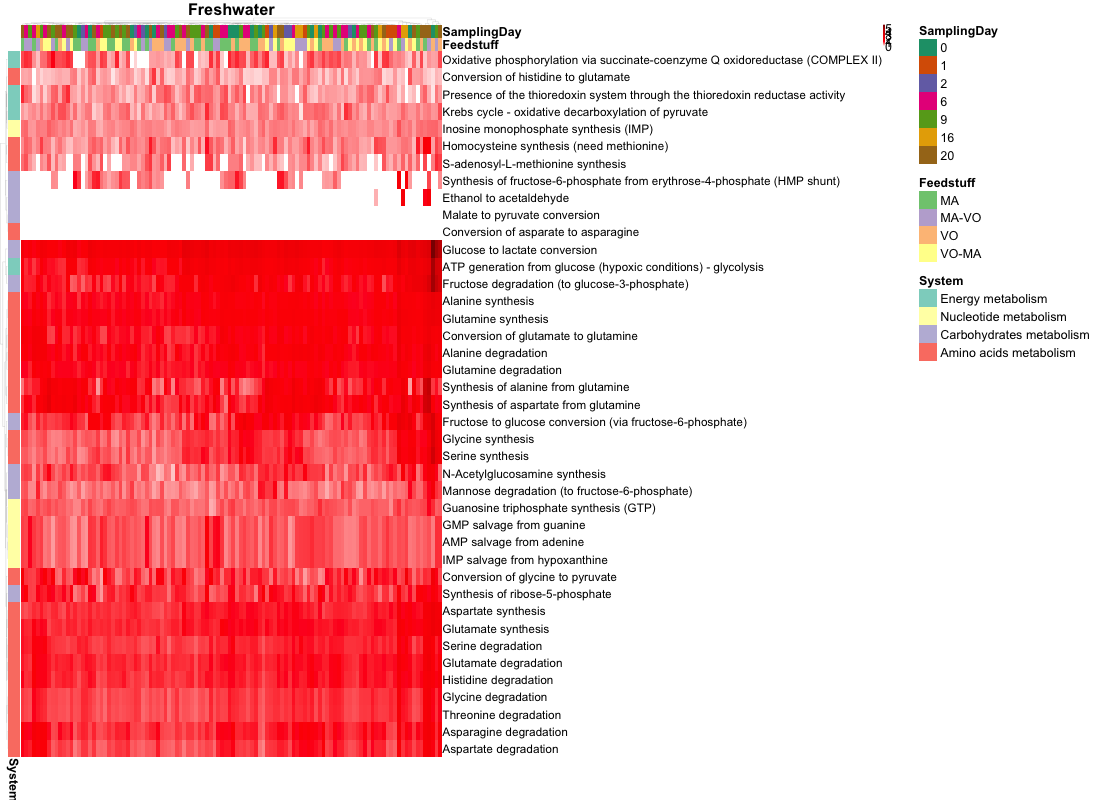

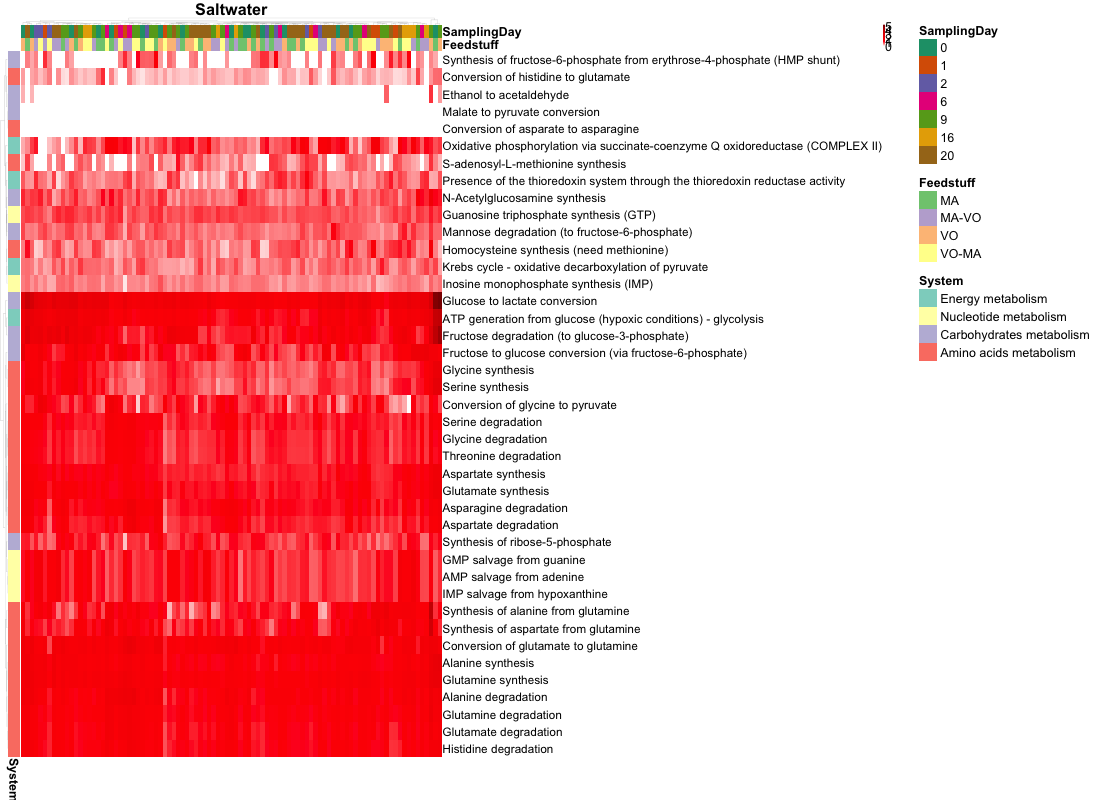

In [23]:
%%R -w 110 -h 80 --units in -r 10

# Set working directory
setwd('~/Git/msc-hm')

# Import needed modules
suppressMessages(
    paste(library(tidyverse),
    library(readxl),
    library(pheatmap), sep="")
)


# Read data files
df <- read.csv('MT_scores/sasa_iMAT.csv', 
               row.names = 1, check.names = FALSE)
df <- as.matrix(df)

meta <- read.table('salmon_feed_switch.sample_meta.txt')


suppressMessages(
  tasks <- read_excel('Tasks.xlsx') 
)
tasks <- filter(tasks, !is.na(ID)) %>% select(2:4)

# Separating into two dataframes, one for each lifestage, i.e. freshwater (fw), saltwater (sw)
idx <- which(meta$water[meta$sample %in% colnames(df)] == 'freshwater')

fw <- df[, idx]
sw <- df[, -idx]


###################################################################################
#                                                                                 #
#                                  Freshwater                                     #
#                                                                                 #
###################################################################################


# Get lifestage, feedstuff and system info in separate vectors
fw_feed <- meta$feed[meta$sample %in% colnames(fw)]


# Getting factor levels in a vector
days <- c()
for(i in 0:50){
  if(sum(str_detect(colnames(df), str_c('D', i))) != 0){
    days <- c(days, i)
  }
}

# Get sampling day, feedstuff and system info in separate vectors
fw_day <- factor(meta$day[meta$sample %in% colnames(fw)], 
              levels = as.character(days))


idx <- tasks$DESCRIPTION %in% rownames(fw)
fw_system <- tasks$SYSTEM[idx]
fw_system <- Hmisc::capitalize(str_to_lower(fw_system))


# Create dataframes with row and column annotation information
fw_row_annot <- data.frame('Feedstuff' = fw_feed, 'SamplingDay' = fw_day)
rownames(fw_row_annot) <- colnames(fw)

fw_col_annot <- data.frame('System' = fw_system)
rownames(fw_col_annot) <- rownames(fw)


# Create distinct colour palette for annotation of systems
fw_distinct_cols_system <- RColorBrewer::brewer.pal(
  length(unique(fw_system)), name='Set3')

fw_distinct_cols_day <- RColorBrewer::brewer.pal(
  length(unique(fw_day)), name = 'Dark2')

fw_distinct_cols_feed <- RColorBrewer::brewer.pal(
  length(unique(fw_feed)), name = 'Accent')



# Store annotation colours in list
fw_ann_colors = list(
  SamplingDay = setNames(fw_distinct_cols_day, levels(fw_day)),
  Feedstuff = setNames(fw_distinct_cols_feed, unique(fw_feed)),
  System = setNames(fw_distinct_cols_system, unique(fw_system))
)



# Plot the heatmap
pheatmap(fw, 
        color = colorRampPalette(c("white", "red1", "red2", "red3", "red4"))(500),
        cluster_rows = TRUE, 
        cluster_cols = TRUE, 
        show_rownames = TRUE, 
        show_colnames = FALSE, 
        annotation_col = fw_row_annot,
        annotation_row = fw_col_annot,
        annotation_colors = fw_ann_colors,
        display_numbers = FALSE,
        fontsize = 90,
        fontsize_row = 85,
        border_color = NA,
        main = "Freshwater")
        #silent = TRUE)


###################################################################################
#                                                                                 #
#                                  Saltwater                                      #
#                                                                                 #
###################################################################################



# Get lifestage, feedstuff and system info in separate vectors
sw_feed <- meta$feed[meta$sample %in% colnames(sw)]


# Get sampling day, feedstuff and system info in separate vectors
sw_day <- factor(meta$day[meta$sample %in% colnames(sw)], 
                 levels = as.character(days))


idx <- tasks$DESCRIPTION %in% rownames(sw)
sw_system <- tasks$SYSTEM[idx]
sw_system <- Hmisc::capitalize(str_to_lower(sw_system))



# Create dataframes with row and column annotation information
sw_row_annot <- data.frame('Feedstuff' = sw_feed, 'SamplingDay' = sw_day)
rownames(sw_row_annot) <- colnames(sw)

sw_col_annot <- data.frame('System' = sw_system)
rownames(sw_col_annot) <- rownames(sw)


# Create distinct colour palette for annotation of systems
sw_distinct_cols_system <- RColorBrewer::brewer.pal(
  length(unique(sw_system)), name='Set3')

sw_distinct_cols_day <- RColorBrewer::brewer.pal(
  length(unique(sw_day)), name = 'Dark2')

sw_distinct_cols_feed <- RColorBrewer::brewer.pal(
  length(unique(sw_feed)), name = 'Accent')



# Store annotation colours in list
sw_ann_colors = list(
  SamplingDay = setNames(sw_distinct_cols_day, levels(sw_day)),
  Feedstuff = setNames(sw_distinct_cols_feed, unique(sw_feed)),
  System = setNames(sw_distinct_cols_system, unique(sw_system))
)


# Plot the heatmap
pheatmap(sw, 
        color = colorRampPalette(c("white", "red1", "red2", "red3", "red4"))(500),
        cluster_rows = TRUE, 
        cluster_cols = TRUE, 
        show_rownames = TRUE, 
        show_colnames = FALSE, 
        annotation_col = sw_row_annot,
        annotation_row = sw_col_annot,
        annotation_colors = sw_ann_colors,
        display_numbers = FALSE,
        fontsize = 90,
        fontsize_row = 85,
        border_color = NA,
        main = "Saltwater")
        #silent = TRUE)